# Module Control Work (MKR) 1
### Шевченко Юлія, ФІ-31мн

In this homework assignment, we will explore the application of the Harris corner detector to detect the corners of a document. Document detection plays a vital role in various applications such as text recognition, automatic passport reading at airport gates, and more.

Additionally, we will be tasked with designing our own feature descriptor to accurately localize and distinguish between the four corners of the document. This feature descriptor is essential for precise corner identification and subsequent processing steps.

Towards the end of this notebook, we will find a set of questions aimed at reinforcing our understanding of the concepts covered. Our responses to these questions will help solidify our grasp of the material covered in this assignment.

So, let's embark on this journey of document corner detection and feature descriptor design. Shall we?

In [1]:
# All the imports for the task
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Let's read the image
image_path = '../MKR_1/document.jpg'
img = cv2.imread(image_path)

# Convert it to a gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray) / 255
rows, cols = gray.shape

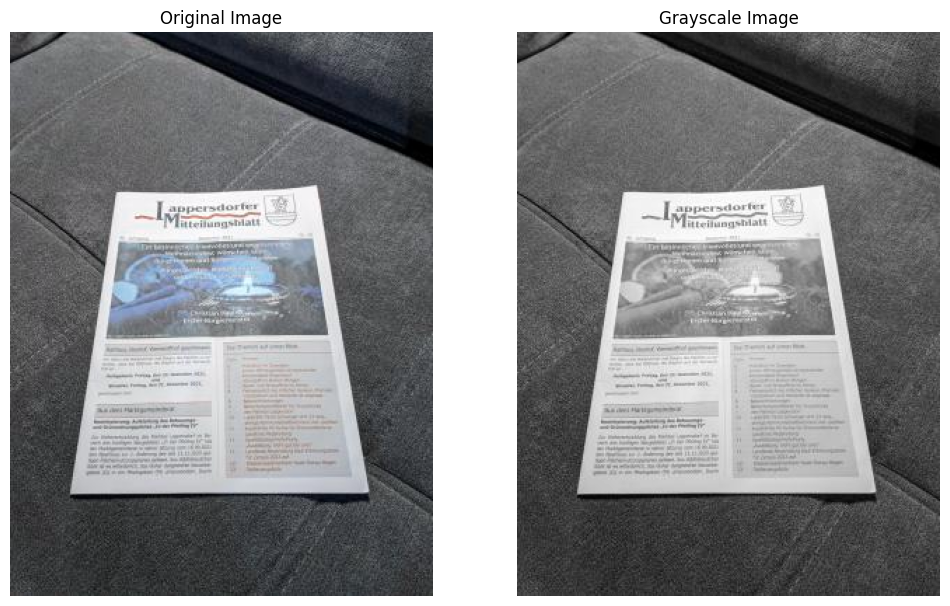

In [3]:
# Let's plot the images (color and gray scale)
plt.figure(figsize=(12, 8))
    
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
    
plt.show()

## Harris Corner Detector

The Harris Corner Detector is a widely used algorithm in computer vision for corner detection. It was proposed by Chris Harris and Mike Stephens in 1988. The main idea behind the Harris Corner Detector is to identify points in an image where there are significant variations in intensity in all directions. These points are considered as corners, which are key features in image analysis and pattern recognition tasks.

### How Harris Corner Detector Works:

1. **Intensity Gradient Calculation**: The algorithm computes the gradient of the image intensity at each pixel using techniques such as Sobel or Prewitt operators. This step helps to identify regions with significant changes in intensity.

2. **Structure Tensor Calculation**: Harris Corner Detector computes the structure tensor for each pixel in the image. The structure tensor captures the local variation in intensity in different directions.

3. **Corner Response Function**: Using the structure tensor, the algorithm calculates a corner response function for each pixel. This function measures the likelihood of a pixel being located at a corner based on the local intensity variations.

4. **Non-maximum Suppression**: After computing the corner response function, non-maximum suppression is applied to identify local maxima in the response function. These local maxima correspond to potential corner locations.

5. **Thresholding and Corner Selection**: Finally, a threshold is applied to the corner response function to select the most prominent corners. These selected corners are considered as the output of the Harris Corner Detector.

### Applications of Harris Corner Detector:

- **Feature Detection**: Harris Corner Detector is widely used in feature detection tasks, such as image registration, object recognition, and motion tracking.
- **Image Stitching**: In panorama stitching applications, Harris corners are used to identify key points in images for aligning and blending multiple images.
- **Structure from Motion**: In computer vision applications like 3D reconstruction from multiple images, Harris corners help in estimating the camera motion and scene structure.

The Harris Corner Detector provides a robust and efficient method for corner detection, making it a valuable tool in various computer vision applications.

In [4]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness[cornerness < 0] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

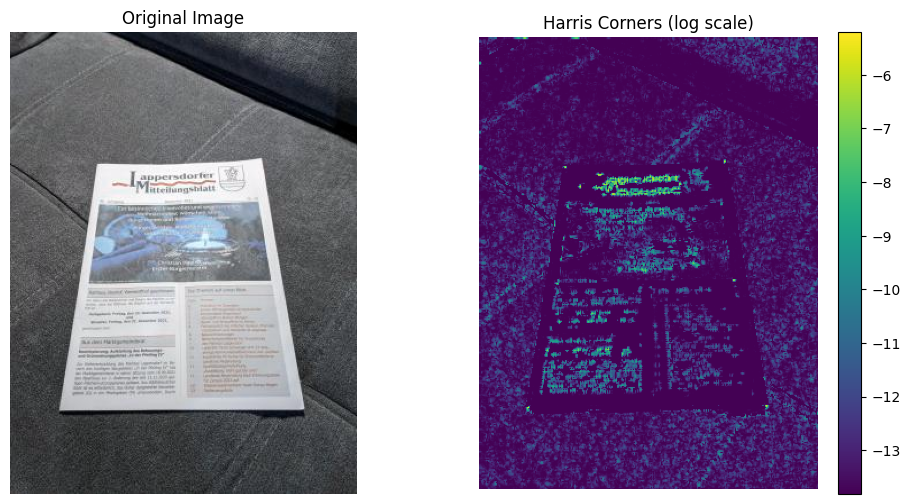

In [5]:
# Let's now plot the image and the corresponding Harris corners (in a log scale)
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(cornerness)
plt.title('Harris Corners (log scale)')
plt.colorbar()
plt.axis('off')
    
plt.show()

At this point, we can observe that the Harris detector has successfully detected numerous features in the image. However, along with the four document corners, it has also identified corners corresponding to printed letters on the paper. To filter out everything except the four document corners, we need to design a custom feature descriptor tailored for detecting these corners accurately.

To design an effective feature descriptor for detecting the document corners, let's examine the top-left corner of the document:

![Top-left corner](../MKR_1/document_descriptor_example.jpg "Top-left corner")

A suitable descriptor for this corner, considering a certain neighboring region, would involve assessing that the bottom-right quadrant is significantly brighter than the other three quadrants (i.e., top-left, top-right, bottom-left). This distinct brightness pattern can help us identify the document corner accurately.

To implement the custom feature descriptor, we will start by focusing in the top-left corner. I'll provide the initial implementation for the top-left corner, and our task will be to extend this approach to handle the remaining corners of the document.

Let's proceed with the implementation and fine-tuning of our custom feature descriptor to achieve precise corner detection for the document.


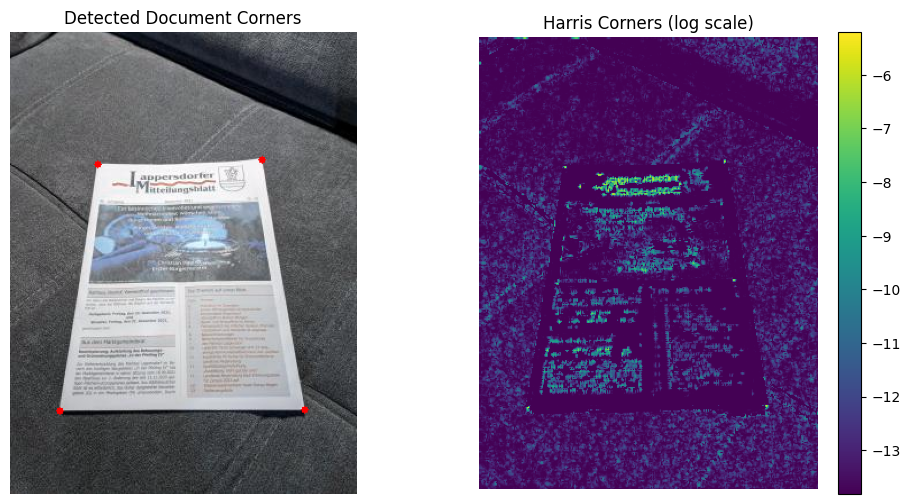

In [6]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue

        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]

        # Extract the four quadrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, -quad_size:]
        quad_bottom_left = block[-quad_size:, 0:quad_size]
        quad_bottom_right = block[-quad_size:, -quad_size:]

        # Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quadrant and the sum of the 3 remaining background quadrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)

        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
                     np.mean(quad_top_right) - np.mean(quad_top_left) - np.mean(quad_bottom_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)

        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
                     np.mean(quad_bottom_left) - np.mean(quad_bottom_right) - np.mean(quad_top_left)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)

        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                     np.mean(quad_bottom_right) - np.mean(quad_bottom_left) - np.mean(quad_top_right)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(out, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(out, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(out, opt_bottom_right, 3, (255,0,0), -1)

# And finally, we plot the images (with the detected document corners)
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.imshow(out)
plt.title('Detected Document Corners')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(cornerness)
plt.title('Harris Corners (log scale)')
plt.colorbar()
plt.axis('off')
    
plt.show()

## Questions

1.  Does it matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera? How?

    Yes, it does matter whether the picture has been taken by a 1Mpx camera or a 12Mpx camera, especially when considering computational efficiency and the robustness of feature detection.

    -   Computational Efficiency: A 12Mpx image contains significantly more pixels compared to a 1Mpx image. Processing a higher resolution image requires more computational resources and time. Therefore, algorithms designed for lower resolution images might face performance issues when applied to higher resolution images. For instance, in the Harris corner detection algorithm, the number of iterations required to scan through each pixel and compute the cornerness score would increase dramatically with higher resolution images. This could potentially lead to longer processing times, making real-time applications impractical with higher resolution images.

    -   Robustness of Feature Detection: Higher resolution images contain finer details and more information compared to lower resolution images. In the context of feature detection algorithms like Harris corner detection, this means there could be more potential corners or key points present in a higher resolution image. However, this doesn't necessarily mean that all features detected will be meaningful or relevant. Noise, variations in lighting conditions, and other factors may cause the algorithm to detect spurious features. Therefore, while the algorithm might detect more features in a higher resolution image, it might also introduce more false positives or irrelevant key points, which could affect subsequent processing steps such as feature matching or object recognition.

    In summary, while higher resolution images provide more detailed information, they also pose challenges in terms of computational efficiency and the reliability of feature detection algorithms.

2.  If we increased the resolution of the camera, what would you change in the current algorithm?

    Increasing the resolution of the camera would necessitate adjustments in the current algorithm to accommodate the higher resolution images and potentially improve the robustness and efficiency of feature detection. Here are some considerations:

    -   Scale of Operations: With higher resolution images, the size of the image matrix increases, affecting the scale of operations within the algorithm. For instance, parameters such as the size of the neighborhood for computing the Harris corner response, the size of the quadrants for custom feature descriptor assessment, and the thresholds for feature detection might need to be adjusted to account for the increased image size. This could involve scaling these parameters proportionally to maintain consistency in feature detection across different resolutions.

    -   Optimization for Efficiency: Higher resolution images require more computational resources for processing. To ensure efficient processing, optimizations such as parallelization of computations, utilization of optimized libraries or hardware acceleration (e.g., GPU processing), and algorithmic optimizations (e.g., reducing redundant calculations) may be necessary. These optimizations can help mitigate the increased computational burden associated with higher resolution images and enable real-time or near-real-time performance.

    -   Adaptation to Fine Details: Higher resolution images contain finer details and more intricate features compared to lower resolution counterparts. The algorithm may need to be adapted to effectively capture and utilize these fine details for feature detection. This could involve refining the custom feature descriptor to leverage the additional information present in higher resolution images, thereby enhancing the discriminative power and accuracy of feature detection.

    -   Robustness to Noise and Variability: Increasing the resolution can also amplify noise and variations in the image, which may affect the reliability of feature detection. Enhancing the algorithm's robustness to noise and variability through techniques such as noise reduction preprocessing, robust feature descriptor design, and adaptive thresholding can help improve the accuracy and consistency of feature detection across different resolutions.

    Overall, adapting the algorithm to accommodate higher resolution images involves a combination of adjusting parameters, optimizing for efficiency, leveraging fine details, and enhancing robustness to variability, ultimately aiming to maintain the effectiveness and reliability of feature detection in varying imaging conditions.